# Makemore: bigrams model

### [The spelled-out intro to language modeling: building makemore](https://www.youtube.com/watch?v=PaCmpygFfXo)
___

In [1]:
import torch
import string
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# !wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

In [3]:
with open('names.txt','r') as f:
    names = f.read().splitlines()

In [4]:
len(names)

32033

we initially used `<S>` and `<E>` as the start and end token respectively but in the lookup table N, there as cases where there's a character before `<S>` or there's a character after `<S>` which is not possible.
    
to make it slightly better. Instead of using `<S>` and `<E>` substituting it for a single `.` character which indicates both the start and the end

In [5]:
# tokens = ['<S>','<E>'] + list(string.ascii_lowercase)
tokens = ['.'] + list(string.ascii_lowercase)

In [6]:
t_i = {t:i for i,t in enumerate(tokens)}
i_t = {i:t for t,i in t_i.items()}

sample bigrams:

In [7]:
for word in names[:3]:
    word = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(word,word[1:]):
        print(ch1,ch2)

. e
e m
m m
m a
a .
. o
o l
l i
i v
v i
i a
a .
. a
a v
v a
a .


In [8]:
bigram_counts = dict()

In [9]:
for word in names:
    word = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(word,word[1:]):
        bigram = (ch1,ch2)
        bigram_counts[bigram] = bigram_counts.get(bigram, 0) + 1

In [10]:
sorted_bigram_counts = sorted(bigram_counts.items(), key=lambda x:x[1], reverse=True)
sorted_bigram_counts[:5]

[(('n', '.'), 6763),
 (('a', '.'), 6640),
 (('a', 'n'), 5438),
 (('.', 'a'), 4410),
 (('e', '.'), 3983)]

bigram lookup table:

In [11]:
N = torch.zeros((27,27), dtype=torch.int32)

In [12]:
for word in names:
    word = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(word,word[1:]):
        r = t_i[ch1]
        c = t_i[ch2]
        N[r,c] += 1

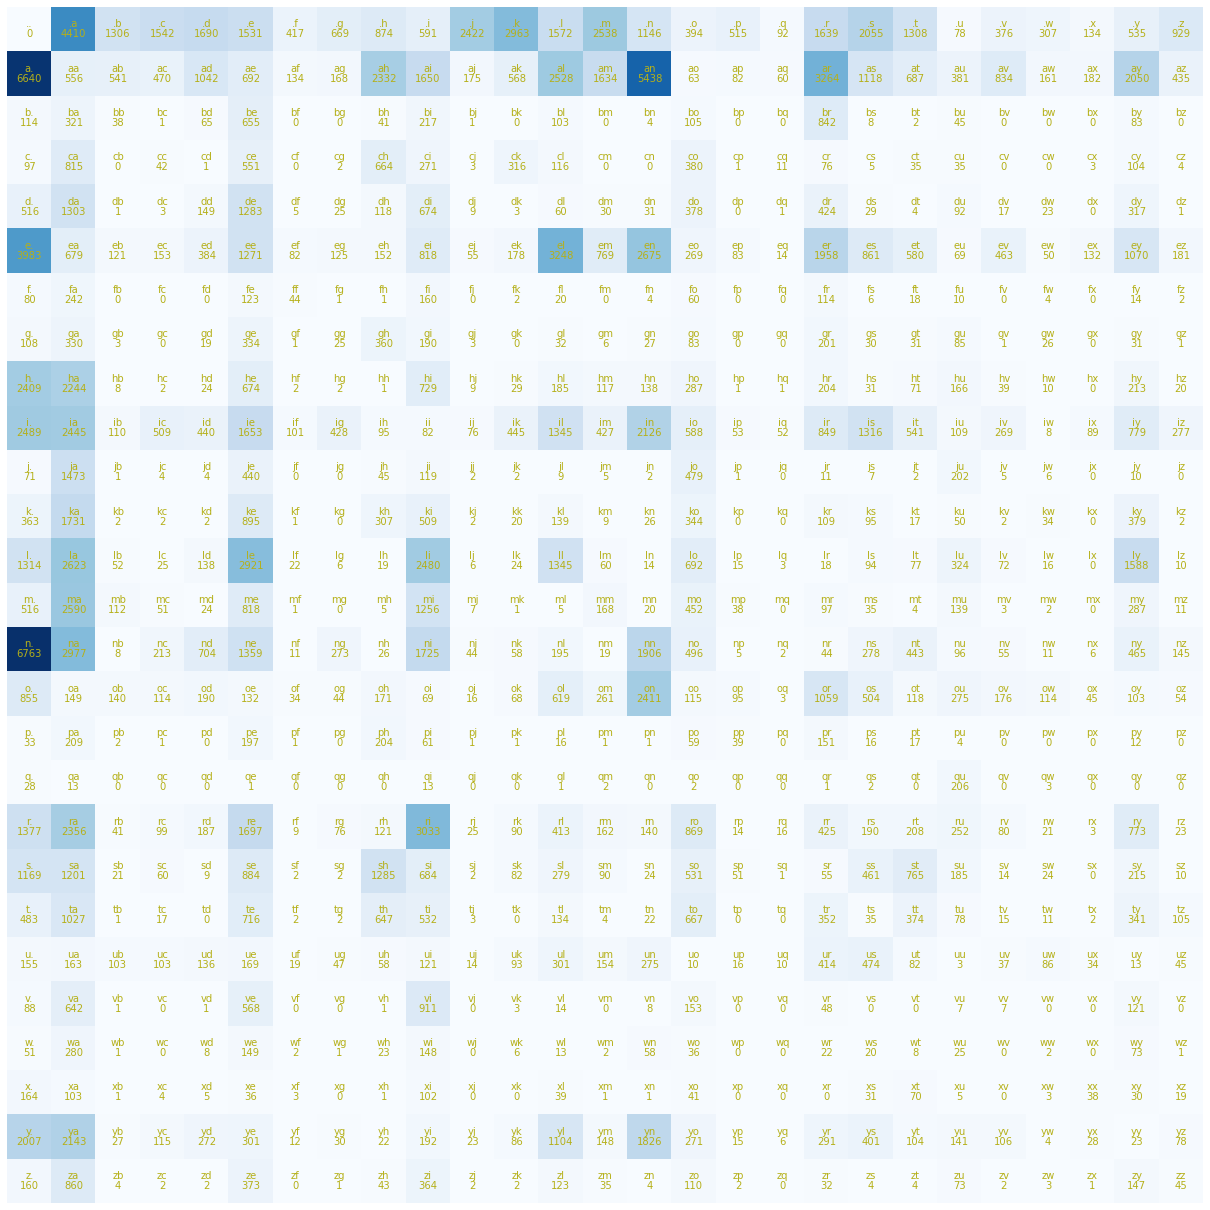

In [13]:
plt.figure(figsize=(22,22))
plt.axis('off')
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = i_t[i] + i_t[j]
        plt.text(j,i,chstr,ha='center',va='bottom',color='#b5b019')
        plt.text(j,i,N[i,j].item(),ha='center',va='top',color='#b5b019')
plt.savefig('bigrams_lookup_table.png',bbox_inches='tight')

___

In [14]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [15]:
gen = torch.Generator().manual_seed(2147483647)
p = torch.rand(3, generator=gen)
p /= p.sum()
p

tensor([0.6064, 0.3033, 0.0903])

In [16]:
# then with the generator, we can sample ints using multinomial
# here ~60% will be 0, ~30% will be 1 and ~2$ will be 2
torch.multinomial(p,num_samples=20, replacement=True,generator=gen)

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [17]:
# normalize: this gives a probability distribution across the row, and sum=1
p = N[0].float()
p /= p.sum()
p, p.sum() 

(tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
         0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
         0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290]),
 tensor(1.))

In [18]:
idx = torch.multinomial(p,num_samples=1, replacement=True,generator=gen).item()
idx, i_t[idx]

(11, 'k')

In [19]:
# for the next character, go to row 'e' and so on
seed = 2147483647
gen = torch.Generator().manual_seed(seed)
idx = 0 # start token

for i in range(25):
    name = ''
    while True:
        """
        what if every first character were equally likely?
        p = torch.ones(27) / 27.0
        this is gonna be garbage indicating untrained.
        """
        p = N[idx].float()
        p /= p.sum()
        idx = torch.multinomial(p,num_samples=1, replacement=True,generator=gen).item()
        name += i_t[idx]
        if idx == 0:
            break
    print(name)

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.
odaren.
iaddash.
h.
jhinatien.
egushl.
h.
br.
a.
jayn.
ilemannariaenien.
be.
f.
akiinela.
trttanakeroruceyaaxatona.
lamoynayrkiedengin.
torrederahnn.
ellovyllobrpin.
a.
wai.
kn.


___
more efficiently:

In [20]:
N.shape

torch.Size([27, 27])

In [21]:
# instead of calculating p for each row, let's create a P matrix which already has probabilities for each row

P = N.float()


"""
broadcasting rules:

1. align the shapes towards the right
27,27
27
becomes
27,27
   27
   
2. broadcasting is possible when any  of the individual sizes are either:
    -> equal
    -> missing
    -> or 1
    

# keepdims=True is important since we want to divide along the rows
# otherwise, we'll lose that row dimensionality and we'll end up diving along the cols

we need:
27, 27
27,  1
instead of 
27,27
 1,27
"""
P /= P.sum(dim=1, keepdims=True)

In [22]:
P.sum(dim=1) # this worked

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [23]:
# lets generate again but efficiently
seed = 2147483647
gen = torch.Generator().manual_seed(seed)
idx = 0
for i in range(25):
    name = ''
    while True:
        p = P[idx,:]
        idx = torch.multinomial(p,num_samples=1, replacement=True,generator=gen).item()
        name += i_t[idx]
        if idx == 0:
            break
    print(name)

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.
odaren.
iaddash.
h.
jhinatien.
egushl.
h.
br.
a.
jayn.
ilemannariaenien.
be.
f.
akiinela.
trttanakeroruceyaaxatona.
lamoynayrkiedengin.
torrederahnn.
ellovyllobrpin.
a.
wai.
kn.


if we look at the probabilities of some bigrams, learnt stuff are above 4% and some even 35%+

Loss: log likelihood
```
if we have probabilities a,b,c
then likelihood = a*b*c
then log likelihood = log(abc) = log(a) + log(b) + log(c)
log likelihood starts at 0

if all probs are 1 then log likelihood = 0
and if probs are lower then it goes more and more negative

so we need to invert this since low means good as loss
```

In [36]:
log_likelihood = 0.0
n = 0
for word in names[:3]:
    word = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(word,word[1:]):
        r = t_i[ch1]
        c = t_i[ch2]
        prob = P[r,c]
        # higher numbers are closer to zero
        # 
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        print(f'{ch1}{ch2}: {prob:.4f} : {logprob:.4f}')

nll = -log_likelihood
normalized_nll = nll/n
print(f"{nll=} {normalized_nll=}")

.e: 0.0478 : -3.0408
em: 0.0377 : -3.2793
mm: 0.0253 : -3.6772
ma: 0.3899 : -0.9418
a.: 0.1960 : -1.6299
.o: 0.0123 : -4.3982
ol: 0.0780 : -2.5508
li: 0.1777 : -1.7278
iv: 0.0152 : -4.1867
vi: 0.3541 : -1.0383
ia: 0.1381 : -1.9796
a.: 0.1960 : -1.6299
.a: 0.1377 : -1.9829
av: 0.0246 : -3.7045
va: 0.2495 : -1.3882
a.: 0.1960 : -1.6299
nll=tensor(38.7856) normalized_nll=tensor(2.4241)


### goal:
- maximize likelihood of the data wrt model parameters (statistical modeling)
- equivalent to maximizing log likelihood (log is monotonic)
- equivalent to minimizing negative log likelihood
- equivalent to minimizing the average negative log likelihood

### upcoming:

the probabilities will be calculated by neural networks instead of using a lookup table
and we've to reach the goal


In [38]:
# for the entire dataset

log_likelihood = 0.0
for word in names:
    word = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(word,word[1:]):
        r = t_i[ch1]
        c = t_i[ch2]
        prob = P[r,c]
        logprob = torch.log(prob)
        log_likelihood += logprob

nll = -log_likelihood
normalized_nll = nll/len(names)
print(f"{nll=} {normalized_nll=}")

nll=tensor(559891.7500) normalized_nll=tensor(17.4786)


BUG: if any probability is 0, then log will be undefined, here inf, so to combat that, we add fake counts

more the fake counts, more the smoothing

In [39]:
log_likelihood = 0.0
for word in ['somenamejq']:
    word = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(word,word[1:]):
        r = t_i[ch1]
        c = t_i[ch2]
        prob = P[r,c]
        logprob = torch.log(prob)
        log_likelihood += logprob

nll = -log_likelihood
normalized_nll = nll/len(names)
print(f"{nll=} {normalized_nll=}")

nll=tensor(inf) normalized_nll=tensor(inf)


____
# Bi-grams Model


In [40]:
with open('names.txt','r') as f:
    names = f.read().splitlines()

In [41]:
tokens = ['.'] + list(string.ascii_lowercase)

In [42]:
t_i = {t:i for i,t in enumerate(tokens)}
i_t = {i:t for t,i in t_i.items()}

In [43]:
N = torch.zeros((27,27), dtype=torch.int32)

In [44]:
for word in names:
    word = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(word,word[1:]):
        r = t_i[ch1]
        c = t_i[ch2]
        N[r,c] += 1

In [45]:
P = (N+1).float() # adding 1 to remove zero counts to avoid log(0)
P /= P.sum(dim=1, keepdims=True)

In [46]:
seed = 2147483647
gen = torch.Generator().manual_seed(seed)
idx = 0
for i in range(25):
    name = ''
    while True:
        p = P[idx,:]
        idx = torch.multinomial(p,num_samples=1, replacement=True,generator=gen).item()
        name += i_t[idx]
        if idx == 0:
            break
    print(name)

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.
odaren.
iaddash.
h.
jhinatien.
egushl.
h.
br.
a.
jayn.
ilemannariaenien.
be.
f.
akiinela.
trttanakeroruceyaaxatona.
lamoynayrkiedengin.
torrederahnn.
ellovyllobrqura.
ay.
h.
kn.


### NLL: negative log-likelihood loss
quality of the model, lower the loss, better the model

In [47]:
log_likelihood = 0.0
for word in names:
    word = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(word,word[1:]):
        r = t_i[ch1]
        c = t_i[ch2]
        prob = P[r,c]
        logprob = torch.log(prob)
        log_likelihood += logprob

nll = -log_likelihood
normalized_nll = nll/len(names)
print(f"{nll=} {normalized_nll=}")

nll=tensor(559951.5625) normalized_nll=tensor(17.4805)
